## ROMIU ROM ALGORITHM VALIDATION 

A validation analysis of ROMIU with data from motion capture system and a high resolution encoder.

**Standard Modules**

In [64]:
%matplotlib inline
import mpld3
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 
import math
from scipy import interpolate
from scipy.signal import savgol_filter
import csv
import pingouin as pg
mpld3.enable_notebook()

**Cutsom functions**

In [65]:
def get_the_data_path(data_dir):
    """get the path of all the files
    """
    data_path = []
    sub_dir1 = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
    for file_1 in sub_dir1:
        sub_dir2 = [os.path.join(file_1, file) for file in os.listdir(file_1)]
        for file_2 in sub_dir2:
            sub_dir3 = [os.path.join(file_2, file) for file in os.listdir(file_2)]
            for file_3 in sub_dir3:
                sub_dir4 = [os.path.join(file_3, file) for file in os.listdir(file_3)]
                for file_4 in sub_dir4:
                    sub_dir5 = [os.path.join(file_4, file) for file in os.listdir(file_4)]
                    for file_5 in sub_dir5:
                        _data_path = [os.path.join(file_5, file) for file in os.listdir(file_5)]
                        data_path.append(_data_path)
    return data_path

In [127]:
def get_the_enc_data_path(data_dir):
    """
    get the path of all the files
    """
    data_path = []
    sub_dir1 = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]         
    for file_1 in sub_dir1:
        _data_path = [os.path.join(file_1, file) for file in os.listdir(file_1)]
        data_path.append(_data_path)
    return data_path

In [66]:
def upsample_mocap_data(imu: pd.DataFrame, mcp: pd.DataFrame) -> pd.DataFrame:
     """upsample the mocap data to match the sampling frequency of imu data.

     Parameters
     ----------
     imu: pandas.DataFrame 
          DataFrame consisting of time, accelerometer and gyroscope data
     mcp: pandas.Dataframe
          DataFrame consisting of time, position of markers

     Returns
     -------
     pandas.DataFrame
          Returns DataFrame consisting upsampled motion capture data consisting
          of time, position of markers.
     """
    
     _t = imu.Time
     _anew = pd.DataFrame()
     _anew['Time'] = _t
     for col in mcp.columns:
          f = interpolate.interp1d(mcp.Time,mcp[col],fill_value="extrapolate")
          _anew[col]=f(_t)
     mcp=_anew
     return mcp

In [67]:
def read_filter_data(fname: str, datacols: list, filtcols: list, sgwin: int, sgorder: int) -> pd.DataFrame:
    """read the comma-seperated values(csv) file and low pass filter the selected columns

    Parameters
    ----------
    fname:    str
              A comma-seperated vlalues(csv) file.
    datacols: list
              list of columns in the csv file.
    filtcols: list
              list of columsn in the csv file to be filterd.
    sgwin:    int
              The length of the filter window
    sgorder:  int
              The order of the polynomial used to fit the samples

    Returns
    -------
    pandas.DataFrame
        Returns DataFrame with the selected data of selected columsn low pass filtered.
    """
    _data = pd.read_csv(fname, usecols=datacols)
    for fc in filtcols:
        _data[fc] = savgol_filter(_data[fc], sgwin, sgorder)
    return _data

In [132]:
def imu_calibration(imu, acc_A, acc_bias, gyr_bias):
    """perform the calibration of IMU 
    """
    acc = imu[["accelx1", "accely1", "accelz1"]].values
    gyro = imu[["gyrox1", "gyroy1", "gyroz1"]].values
    if np.max(acc) >100:
        acc = acc.astype(float)/16384.0
        gyro = gyro.astype(float)/65.5
    else:
        acc = acc.astype(float)
        gyro = gyro.astype(float)
    acc -= acc_bias
    acc = acc_A @ acc.T
    _var_gyro_offst = np.var(gyro[:1000],axis = 0)
    _mean_gyro_offst = np.mean(gyro[:1000],axis = 0)
    if np.max(_var_gyro_offst)<5.5:
        gyro -= _mean_gyro_offst
    else:
        gyro -= gyr_bias
    return acc.T, np.deg2rad(gyro)

In [ ]:
def gram_schmidt_orthogonalize(x: np.ndarray, y: np.ndarray) -> tuple((np.ndarray, np.ndarray)):
    """Perform the Gram-Schmidt orthogonalization.

    Parameters
    ----------
    x : np.ndarray
        2D array of number corresponding to the x vector. The columns are the
        different components, while the rows are different x vectors.

    y : np.ndarray
        2D array of number corresponding to the y vector. The columns are the
        different components, while the rows are different y vectors.

    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        Returns the GS orthogonalized (x_normn, y_norm) vectors, with the rows corresponding
        to the different orthogonalized vectors, and the columsn corresponding
        to the different components.
        The norm of the rows of x_norm and y_norm will 1. The dot product of
        the rows of the x_norm nad y_norm will be 0.
    """
    assert type(x) == np.ndarray, "x must be an numpy ndarray."
    assert type(y) == np.ndarray, "x must be an numpy ndarray."
    assert len(x.shape) == 2, "x must be anb 2D numpy array."
    assert len(y.shape) == 2, "x must be anb 2D numpy array."
    assert x.shape == y.shape, "x and y must have the same shape"

    _xn = x / np.linalg.norm(x, axis=1, keepdims=True)
    _yx = np.sum(y * _xn, axis=1, keepdims=True)
    _dy = y - _xn * _yx
    _yn = _dy / np.linalg.norm(_dy, axis=1, keepdims=True)
    return _xn, _yn

In [165]:
def axis_of_rotation_deviation(gyro, delta_t, inertial_quat):
    """
    Compute the deviation of axis of rotation 
    """
    axs_of_rot, delta_theta, q_gyro = angle_axis_quaternion_representation(gyro,delta_t)
    q_int = quaternion_integration(q_gyro,inertial_quat)
    tx, ty, tz = euler_angles_from_quaternion_array(q_int)
    gyro_ang = 2*np.arccos(q_int[:, 0])
    ang = np.rad2deg(gyro_ang)
    index =  next(x for x, val in enumerate(ang[0:np.argmax(ang)]) if val > np.max(ang)*0.7)
    axis_of_rotation_wrt_inertial_frame = np.divide(q_int[:,1:], np.array([np.sin(gyro_ang/2), np.sin(gyro_ang/2), np.sin(gyro_ang/2)]).T)
    fixed_axis = axis_of_rotation_wrt_inertial_frame[index]/np.linalg.norm(axis_of_rotation_wrt_inertial_frame[index])
    norm_axis_of_rot = np.divide( axis_of_rotation_wrt_inertial_frame, np.linalg.norm(axis_of_rotation_wrt_inertial_frame, axis = 1, keepdims= True))
    dev_ip = norm_axis_of_rot @ fixed_axis
    dev  = np.rad2deg(np.arccos(np.clip(dev_ip, a_min= -1, a_max= 1)))
    return dev, ang, tx, ty, tz

**Quaternion operations**

In [69]:
def quaternion_multiply(quaternion1: np.ndarray, quaternion0: np.ndarray) -> np.ndarray:
    """Perfomre quaternion multiplication

    Parameters
    ----------
    quaternion1: np.ndarray
                 1D array of 4 numbers
    quaternion2: np.ndarray
                 1D array of 4 numbers

    Returns
    -------
    np.ndarray
        Returns 1D array of 4 numbers.
    """
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

In [73]:
def inverse_of_quaternion_array(quaternion_array):
    """
    Perform the inverse of a quaternion array
    """
    inverse = np.divide(quaternion_array, np.linalg.norm(quaternion_array, axis = 1, keepdims = True))
    inverse[:, -3:] *= -1
    return inverse

In [74]:
def vec_quaternion(acc):
    """ 
    return vector as a quaternion with zero as first number
    """
    q_acc = np.hstack([np.zeros((len(acc),1)), acc])
    return q_acc

In [75]:
def quaternion_vector_rotation(quat, vec):
    """
    Perform vector rotation with quaternion
    """
    first_prod = [quaternion_multiply(quat[j], vec[j]) for j in range(len(quat))]
    rot_vect = [quaternion_multiply(first_prod[j], inverse_of_quaternion_array(quat)[j]) for j in range(len(quat))]
    return rot_vect

In [76]:
def quaternion_integration(quaternion,inertial_quat):
    """ 
    Perform quanternion integration
    """
    q_int = np.vstack([np.array(inertial_quat).reshape(1,4),np.zeros(((len(quaternion)-1),4))])
    for j in range(len(quaternion)-1):
        q_int[j+1] = quaternion_multiply(q_int[j],quaternion[j+1])
        q_int[j+1] = q_int[j+1]/np.linalg.norm(q_int[j+1])
    return q_int

In [77]:
def angle_axis_quaternion_representation(gyro,delta_t):
    """
    compute the angle axis  and quaternion representation of gyroscope data
    """
    inst_axs_of_rot = np.divide (gyro, np.linalg.norm(gyro, axis = 1, keepdims = True))
    delta_theta = np.linalg.norm(gyro, axis = 1)*delta_t
    q_gyro = np.column_stack([np.cos(delta_theta/2), inst_axs_of_rot*(np.sin(delta_theta/2)[:, np.newaxis])])
    return inst_axs_of_rot, delta_theta, q_gyro

In [80]:
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians

In [81]:
def euler_angles_from_quaternion_array(quaternion_array):
    """
    Get euler angles form quaternion array
    """
    tx1 = []
    ty1 = []
    tz1 = []
    for quat in quaternion_array:
        tx, ty, tz = euler_from_quaternion(quat[1], quat[2], quat[3], quat[0])
        tx1.append(tx)
        ty1.append(ty)
        tz1.append(tz)
    return tx1, ty1, tz1

**Notebook level constants**

In [172]:
imu_col =['gyrox1', 'gyroy1', 'gyroz1', 'accelx1', 'accely1', 'accelz1',  'Time']
imu_enc_col =['gyrox1', 'gyroy1', 'gyroz1', 'accelx1', 'accely1', 'accelz1', 'enc_ang', 'Time']
mcp_col=['Time', 'org_x', 'org_y', 'org_z', 'xvec_x', 'xvec_y', 'xvec_z', 'zvec_x', 'zvec_y', 'zvec_z']

acc_A = np.array([[2.007463, -0.000148, 0.002320],
                   [-0.000148, 1.993274, -0.000060],
                   [0.002320, -0.000060, 1.986062]])
acc_bias = np.array([0.032051, -0.009519, -0.125074])
gyr_bias = np.array([0.32372708, 1.273188007, -1.421987881])
var_lim  = 5.5
delta_t = 0.0017
inertial_quat = [1, 0, 0, 0]
alpha = 0.0000001
beta = 0.000001

header_for_gain_optmize = ['comp_1_max_abs', 'comp_2_max_abs', 'comp_3_max_abs', 'comp_4_max_abs', 'comp_5_max_abs', 'comp_6_max_abs', 'comp_7_max_abs',
                           'madg_1_max_abs', 'madg_2_max_abs', 'madg_3_max_abs', 'madg_4_max_abs', 'madg_5_max_abs', 'madg_6_max_abs', 'madg_7_max_abs',
                           'comp_1_rom_abs', 'comp_2_rom_abs', 'comp_3_rom_abs', 'comp_4_rom_abs', 'comp_5_rom_abs', 'comp_6_rom_abs', 'comp_7_rom_abs',
                           'madg_1_rom_abs', 'madg_2_rom_abs', 'madg_3_rom_abs', 'madg_4_rom_abs', 'madg_5_rom_abs', 'madg_6_rom_abs', 'madg_7_rom_abs', 
                           'gyro_max_abs', 'gyro_rom_abs']
header_final_err = ['gyro_recon_err', 'gyro_rom_err', 'comp_recon_err', 'comp_rom_err', 'madg_recon_err', 'madg_rom_err']
gain = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
dest_key_words_imu_mcp = ['abduction', 'dummy_variab', 'e_rotation', 'i_rotation', 'dummy_variab', 'extension', 
                       'Right_Lateral_flexion', 'Left_Lateral_flexion', 'Right_rotation', 'Left_rotation']  
dest_dir = r'D:\ROMIU\ROMIU_final_results'
dest_file_name_imu_mcp = ['AA', 'FE', 'ER', 'IR','F','E','RLF','LLF', 'RR','LR']
dest_file_name_imu_enc = ['AA', 'FE', 'RR']
dest_key_words_imu_enc = ['abduction', 'flexion', 'rotation']

**Motion Capture**


In [15]:
def estimate_rotation_angle_from_mocap(mcp):
    """
    Estimate joint rotation angle form motion capture data
    """
    _org_mkr = mcp.loc[:, ['org_x', 'org_y', 'org_z']].values
    _xvc_mkr = mcp.loc[:, ['xvec_x', 'xvec_y', 'xvec_z']].values
    _zvc_mkr= mcp.loc[:, ['zvec_x', 'zvec_y', 'zvec_z']].values
    gs_vec = gram_schmidt_orthogonalize(_org_mkr-_xvc_mkr, _xvc_mkr-_zvc_mkr)
    gs_vec = (np.cross(gs_vec[0],gs_vec[1]),) + gs_vec
    ort = np.array(gs_vec).transpose(1, 2, 0)   
    rot_wrt_inertial = ort[0].T @ ort
    mocap_ang = np.rad2deg(np.arccos([np.clip((np.trace(rot)-1.0)/2,a_max = 1, a_min = -1) for rot in rot_wrt_inertial]))
    return mocap_ang  

***Inertial Measurement Unit***

**Gyroscope Integration**

In [16]:
def angle_estimation_through_gyroscope(gyro, delta_t, inertial_quat):
        """
        Estimage joint rotation angle from gyroscope data through integration approach
        """
        axs_of_rot, delta_theta, q_gyro = angle_axis_quaternion_representation(gyro,delta_t)
        q_int = quaternion_integration(q_gyro,inertial_quat)
        gyro_ang = np.rad2deg(2*np.arccos(q_int[:, 0]))
        return gyro_ang

**Complementary Filter**

In [17]:
def tilt_correction_quaternion(q_int, acc, alpha):
    """
    Compute tilt correction quaternion
    """
    acc_rot = quaternion_vector_rotation(q_int, vec_quaternion(acc))
    acc_rot_norm = np.divide(acc_rot, np.linalg.norm(acc_rot, axis = 1, keepdims = True))
    norm_vec = np.cross(acc_rot_norm[:, [1,2,3]], acc[0].reshape(1,3))
    mag_norm_vec = np.linalg.norm(norm_vec, axis = 1, keepdims = True)
    mag_norm_vec[mag_norm_vec == 0] = 1
    axs_of_rot_acc = np.divide(norm_vec, mag_norm_vec)
    delta_theta_acc= np.arccos(np.clip(np.dot(acc_rot_norm[:, [1,2,3]], acc[0])/(np.linalg.norm(acc[0])), a_min = -1, a_max = 1.0))
    q_tilt = np.column_stack([np.cos(alpha*delta_theta_acc/2), axs_of_rot_acc*(np.sin(alpha*delta_theta_acc/2)[:, np.newaxis])])
    return q_tilt

In [18]:
def angle_estimation_through_complementary_filter(gyro, acc, delta_t, inertial_quat, alpha):
    """
    Estimate the joint rotation angle from IMU data through complementary filter
    """
    axs_of_rot, delta_theta, q_gyro = angle_axis_quaternion_representation(gyro,delta_t)
    q_int = quaternion_integration(q_gyro,inertial_quat)
    q_tilt = tilt_correction_quaternion(q_int, acc, alpha)
    q_corr = [np.array(quaternion_multiply(q_tilt[j], q_int[j])) for j in range(len(q_gyro))]
    q_corr_scalar = np.clip(np.array(q_corr)[:, 0], a_min = -1, a_max = 1.0)
    comp_ang = np.rad2deg(2*np.arccos(q_corr_scalar))
    return comp_ang

**Madgwick Filter**

In [92]:
def tilt_correction_estimation_through_madgwick(q_gyro, acc, delta_t, beta, inertial_quat):
    """
    Compute tilt correction through madgwick
    """
    q_corr = np.zeros((len(q_gyro),4))
    q = inertial_quat
    norm_acc = np.divide(acc, np.linalg.norm(acc, axis = 1, keepdims = True))
    for j in range(len(q_gyro)):
        f =np.array( [2*((acc[0,0]*(0.5-(q[2]*q[2])-(q[3]*q[3])))+(acc[0,1]*((q[0]*q[3])+(q[1]*q[2])))+(acc[0,2]*((q[1]*q[3])-(q[0]*q[2])))), 
                      2*((acc[0,0]*((q[1]*q[2])-(q[0]*q[3])))+(acc[0,1]*((0.5-q[1]*q[1])-(q[3]*q[3])))+(acc[0,2]*((q[0]*q[1])+(q[2]*q[3])))),
                      2*((acc[0,0]*((q[0]*q[2])-(q[1]*q[3])))+(acc[0,1]*((q[2]*q[3])-(q[0]*q[1])))+(acc[0,2]*((0.5-q[1]*q[1])-(q[2]*q[2]))))])
        f= f - norm_acc[j]
        Jac = np.array ([[(2*acc[0,1]*q[3])-(2*acc[0,2]*q[2]),(2*acc[0,1]*q[2])+(2*acc[0,2]*q[3]), ((-4*acc[0,0]*q[2])+(2*acc[0,1]*q[1])-(2*acc[0,2]*q[0])),((-4*acc[0,0]*q[3])+(2*acc[0,1]*q[0])+(2*acc[0,2]*q[1]))],
                         [(-2*acc[0,0]*q[3])+(2*acc[0,2]*q[1]),((2*acc[0,0]*q[2])-(4*acc[0,1]*q[1])+(2*acc[0,2]*q[0])),(2*acc[0,0]*q[1])+(2*acc[0,2]*q[3]), ((-2*acc[0,0]*q[0])+(-4*acc[0,1]*q[3])+(2*acc[0,2]*q[2]))],
                         [(2*acc[0,0]*q[2])-(2*acc[0,1]*q[1]), ((2*acc[0,0]*q[3])-(2*acc[0,1]*q[0])-(4*acc[0,2]*q[1])), ( (2*acc[0,0]*q[0])+(2*acc[0,1]*q[3])+(-4*acc[0,2]*q[2])),(2*acc[0,0]*q[1])+(2*acc[0,1]*q[2])]])
        del_f = Jac.T @ f
        if np.linalg.norm(del_f) != 0:
            del_f_norm = np.divide(del_f, np.linalg.norm(del_f))
        else:
            del_f_norm = del_f
        q_tilt = del_f_norm*beta*delta_t
        q = q - q_tilt                 
        q_corr[j] = q
        q = quaternion_multiply(q, q_gyro[j])
    return q_corr

In [20]:
def angle_estimation_through_madgwick(gyro, acc,delta_t, beta, inertial_quat):
    """
    Estimate the joint rotation angle from IMU data throught Madgwick Filter
    """
    axs_of_rot, delta_theta, q_gyro = angle_axis_quaternion_representation(gyro,delta_t)
    q_corr = tilt_correction_estimation_through_madgwick(q_gyro, acc, delta_t, beta, inertial_quat)
    q_corr_scalar = np.clip(np.array(q_corr)[:, 0], a_min = -1, a_max = 1.0)
    madg_ang = np.rad2deg(2*np.arccos(q_corr_scalar))
    return madg_ang

In [178]:
def save_in_dest(data, file, dest_key_words, dest_dir, dest_file_name, extension, header):
    for k in range(len(dest_key_words)):
            if file.find(dest_key_words[k]) != -1:
                index = k   
    if file.find('shoulder') != -1 and file.find('flexion') !=-1:
        index = 1
    if file.find('neck') != -1 and file.find('flexion') !=-1 :
        if  file.find('Right_Lateral_flexion') == -1 and file.find('Left_Lateral_flexion') == -1:
            index =4
    path = os.path.join (dest_dir, dest_file_name[index] + extension)
    if not os.path.exists(path):
        with open(path,'w',newline="") as f_in:
            writer = csv.writer(f_in)
            writer.writerow(header)
    with open(path,'a',newline="") as f_in:
        # Write header unchanged
        writer = csv.writer(f_in)
        writer.writerow(data)

**Optimum gain for Complementary and Madgwick filters for IMU-MOCAP and IMU-Encoder**

In [ ]:
# Run gyro and complementary filter, Madgwick filter for different gains for IMU-MOCAP and save errors in destination path

data_path = get_the_data_path(r'C:\Phase1\IMU_data')
for file in data_path:
    err = np.zeros(30)
    imu_file = file[0]
    mcp_file = file[1]
    imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3)
    mcp = read_filter_data(mcp_file, datacols=mcp_col, filtcols=mcp_col[1:], sgwin=51, sgorder=3)
    mcp = upsample_mocap_data(imu, mcp)
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias)
    mocap_ang = estimate_rotation_angle_from_mocap(mcp)
    gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t,inertial_quat)
    err[28] = np.max(abs(mocap_ang[:-500] - gyro_ang[:-500])) 
    err[29] = abs(np.max(mocap_ang[:-500]) - np.max(gyro_ang[:-500]))
    for j in range(len(gain)):
        comp_ang = angle_estimation_through_complementary_filter(gyro, acc, delta_t, inertial_quat, gain[j])
        madg_ang = angle_estimation_through_madgwick(gyro, acc,delta_t, gain[j], inertial_quat)
        max_abs_err_comp = np.max(abs(mocap_ang[:-500] - comp_ang[:-500])) 
        max_abs_err_madg = np.max(abs(mocap_ang[:-500] - madg_ang[:-500])) 
        rom_abs_err_comp = abs(np.max(mocap_ang[:-500]) - np.max(comp_ang[:-500])) 
        rom_abs_err_madg = abs(np.max(mocap_ang[:-500]) - np.max(madg_ang[:-500]))
        err[j] = max_abs_err_comp
        err[j+7] = max_abs_err_madg
        err[j+14] = rom_abs_err_comp
        err[j+21] = rom_abs_err_madg
    save_in_dest(err, file[0], dest_key_words_imu_mcp, dest_dir, dest_file_name_imu_mcp, '_gain_optim.csv', header_for_gain_optmize)

In [ ]:
# Run gyro and complementary filter, Madgwick filter for different gains for IMU-ENC and save errors in destination path

data_path = get_the_enc_data_path(r'D:\ROMIU\imu_encoder_validation')
data_path = np.concatenate([arr for arr in data_path])  
for file in data_path:
    err = np.zeros(30)
    imu = read_filter_data(file, datacols=imu_enc_col, filtcols=imu_enc_col[3:6], sgwin=251, sgorder=3)
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias)
    gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t ,inertial_quat)
    enc_ang  = (360*(imu.enc_ang - imu.enc_ang[0]))/(4*4096.0)
    err[28] = np.max(abs(abs(enc_ang) - gyro_ang)) 
    err[29] = abs(np.max(abs(enc_ang)) - np.max(gyro_ang))
    for j in range(len(gain)):
        comp_ang = angle_estimation_through_complementary_filter(gyro, acc, delta_t, inertial_quat, gain[j])
        madg_ang = angle_estimation_through_madgwick(gyro, acc, delta_t, gain[j], inertial_quat)
        max_abs_err_comp = np.max(abs(abs(enc_ang) - comp_ang)) 
        max_abs_err_madg = np.max(abs(abs(enc_ang) - madg_ang)) 
        rom_abs_err_comp = abs(np.max(abs(enc_ang)) - np.max(comp_ang)) 
        rom_abs_err_madg = abs(np.max(abs(enc_ang)) - np.max(madg_ang))
        err[j] = max_abs_err_comp
        err[j+7] = max_abs_err_madg
        err[j+14] = rom_abs_err_comp
        err[j+21] = rom_abs_err_madg
    save_in_dest(err, file, dest_key_words_imu_enc, dest_dir, dest_file_name_imu_enc, '_gain_optim_enc.csv', header_for_gain_optmize)

**Reconstruction error and Range of motion error for IMU-MOCAP and IMU-Encoder**

In [93]:
# Compute the errors between IMU and MOCAP using just the gyroscope, complementary filter and madgwick filter and save the data to csv files.
data_path = get_the_data_path(r'C:\Phase1\IMU_data')
for file in data_path:
    err = np.zeros(6)
    imu_file = file[0]
    mcp_file = file[1]
    imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3)
    mcp = read_filter_data(mcp_file, datacols=mcp_col, filtcols=mcp_col[1:], sgwin=51, sgorder=3)
    mcp = upsample_mocap_data(imu, mcp)
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias)
    mocap_ang = estimate_rotation_angle_from_mocap(mcp)
    gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t,inertial_quat)
    comp_ang = angle_estimation_through_complementary_filter(gyro, acc, delta_t, inertial_quat, alpha)
    madg_ang = angle_estimation_through_madgwick(gyro, acc,delta_t, beta, inertial_quat)
    err[0] = np.max(abs(mocap_ang[:-500] - gyro_ang[:-500])) 
    err[1] = abs(np.max(mocap_ang[:-500]) - np.max(gyro_ang[:-500]))
    err[2] = np.max(abs(mocap_ang[:-500] - comp_ang[:-500])) 
    err[3] = abs(np.max(mocap_ang[:-500]) - np.max(comp_ang[:-500])) 
    err[4] = np.max(abs(mocap_ang[:-500] - madg_ang[:-500])) 
    err[5] = abs(np.max(mocap_ang[:-500]) - np.max(madg_ang[:-500]))
    save_in_dest(err, file[0], dest_key_words_imu_mcp, dest_dir, dest_file_name_imu_mcp, '_final_err_imu_mcp.csv', header_final_err)

In [140]:
# Compute the errors between IMU and encoder using just the gyroscope, complementary filter and madgwick filter for IMU-ENC and save the data to csv files.

data_path = get_the_enc_data_path(r'D:\ROMIU\imu_encoder_validation')
data_path = np.concatenate([arr for arr in data_path])  
for file in data_path:
    err = np.zeros(6)
    imu = read_filter_data(file, datacols=imu_col_enc, filtcols=imu_col[3:6], sgwin=251, sgorder=3)
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias)
    gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t ,inertial_quat)
    comp_ang = angle_estimation_through_complementary_filter(gyro, acc, delta_t, inertial_quat, alpha)
    madg_ang = angle_estimation_through_madgwick(gyro, acc, delta_t, beta, inertial_quat)
    enc_ang  = (360*(imu.enc_ang - imu.enc_ang[0]))/(4*4096.0)
    err[0] = np.max(abs(abs(enc_ang) - gyro_ang)) 
    err[1] = abs(np.max(abs(enc_ang)) - np.max(gyro_ang)) 
    err[2] = np.max(abs(abs(enc_ang) - comp_ang)) 
    err[3] = abs(np.max(abs(enc_ang)) - np.max(comp_ang)) 
    err[4] = np.max(abs(abs(enc_ang) - madg_ang)) 
    err[5] = abs(np.max(abs(enc_ang)) - np.max(madg_ang))
    save_in_dest(err, file, dest_key_words_imu_enc, dest_dir, dest_file_name_imu_enc, '_final_err_enc.csv', header_final_err)

**Inter-test and Intra-test reliability**

In [126]:
#Compute the Inter and Intra-test reliability

data_path = get_the_data_path(r'C:\Phase1\IMU_data')
participant = data_path[0][0].split("\\")[3]
joint = data_path[0][0].split("\\")[6]
trial = data_path[0][0].split("\\")[4][-1]
a = 0
ang = []
mean_ang = np.zeros((10,3))
for file in data_path:
    imu_file = file[0]
    imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3)
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias)
    gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t,inertial_quat)
    prev_index = index
    for k in range(len(file_dest_key_words)):
        if file[1].find(file_dest_key_words[k]) != -1:
            index = k   
    if file[1].find('shoulder') != -1 and file[1].find('flexion') !=-1:
        index = 1
    if file[1].find('neck') != -1 and file[1].find('flexion') !=-1 :
        if  file[1].find('Right_Lateral_flexion') == -1 and file[1].find('Left_Lateral_flexion') == -1:
            index =4
    if participant!= file[0].split("\\")[3]:
        for j in range(10):
            path = os.path.join (dest_dir, dest_file_name[j] + '_icc.csv')
            if not os.path.exists(path):
                with open(path,'w',newline="") as f_in:
                    writer = csv.writer(f_in)
                    writer.writerow(['sub','clinician1','rom1','clinician2','rom2'])
            with open(path,'a',newline="") as f_in:
                # Write header unchanged
                writer = csv.writer(f_in)
                writer.writerow([a,'A',mean_ang[j][0],'A',mean_ang[j][1]])
                writer.writerow([a,'B',mean_ang[j][0],'C',mean_ang[j][2]])
        mean_ang = np.zeros((10,3))
        a += 1  
        participant = file[0].split("\\")[3]
    ang .append(np.max(gyro_ang))       
    if joint != file[0].split("\\")[6]:
        joint = file[0].split("\\")[6]
        if trial != file[0].split("\\")[4][-1]:
            trial = file[0].split("\\")[4][-1]
            mean_ang[prev_index][int(file[0].split("\\")[4][-1])-2] = np.mean(ang)
        else:
            mean_ang[prev_index][int(file[0].split("\\")[4][-1])-1] = np.mean(ang)
        ang = []

     


**Errors in ground truth data**

In [164]:
# Compute the length of each vector and angle between vectors on rigid body formed by markers 

data_path = get_the_data_path(r'C:\Phase1\IMU_data')
for file in data_path:    
    mcp_file = file[1]
    imu_file = file[0]
    imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3)
    mcp = read_filter_data(mcp_file, datacols=mcp_col, filtcols=mcp_col[1:], sgwin=5, sgorder=0)
    mcp = upsample_mocap_data(imu, mcp)
    _org_mkr = mcp.loc[:, ['org_x', 'org_y', 'org_z']].values
    _xvc_mkr = mcp.loc[:, ['xvec_x', 'xvec_y', 'xvec_z']].values
    _zvc_mkr = mcp.loc[:, ['zvec_x', 'zvec_y', 'zvec_z']].values
    
    # normalize
    _x1 = _xvc_mkr - _org_mkr
    _x1 /= np.linalg.norm(_x1, axis=1, keepdims=True)
    _x2 = _zvc_mkr - _org_mkr
    _x2 /= np.linalg.norm(_x2, axis=1, keepdims=True)
    _x3 = _zvc_mkr - _xvc_mkr
    _x3 /= np.linalg.norm(_x3, axis=1, keepdims=True)

    # Angles
    _t12 = np.arccos(np.clip(np.sum(_x1 * _x2, axis = 1, keepdims=True), a_min=-1, a_max=1)) 
    _t13 = np.arccos(np.clip(np.sum(_x1 * _x3, axis = 1, keepdims=True), a_min=-1, a_max=1))
    _t12 = np.rad2deg(_t12)
    _t13 = np.rad2deg(_t13)
    for k in range(len(file_dest_key_words)):
        if file[1].find(file_dest_key_words[k]) != -1:
            index = k   
    if file[1].find('shoulder') != -1 and file[1].find('flexion') !=-1:
        index = 1
    if file[1].find('neck') != -1 and file[1].find('flexion') !=-1 :
        if  file[1].find('Right_Lateral_flexion') == -1 and file[1].find('Left_Lateral_flexion') == -1:
            index =4
    path = os.path.join (dest_dir, dest_file_name[index] + '_mocap_deviation.csv')
    if not os.path.exists(path):
        with open(path,'w',newline="") as f_in:
            writer = csv.writer(f_in)
            writer.writerow(['rigid_body_dev'])
    with open(path,'a',newline="") as f_in:
        # Write header unchanged
        writer = csv.writer(f_in)
        writer.writerow([np.max([np.max(abs(_t12 - np.mean(_t12))), np.max(abs(_t13 - np.mean(_t13)))])])
    
        

**Deviation of axis of Rotation**

In [ ]:
# compute the deviation of axis of rotation of imu_mcp data

data_path = get_the_data_path(r'C:\Phase1\IMU_data')
for file in data_path:
    imu_file = file[0]
    imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3)   
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias)    
    aor_dev, gyro_angg, tx, ty, tz = axis_of_rotation_deviation(gyro, delta_t, inertial_quat)
    ind_max = np.argmax(gyro_angg)
    trunc_ang = np.flip(gyro_angg[0:ind_max])         
    ind1 = next(x for x, val in enumerate(trunc_ang) if val < np.max(gyro_angg)*0.15)
    ind2 = next(x for x, val in enumerate(gyro_angg[0:ind_max]) if val > np.max(gyro_angg)*0.85)
    trunc_dev = aor_dev[(ind_max-ind1):ind2]
    if len(trunc_dev) != 0 and np.std(trunc_dev) < 50:
        dev = [np.std(trunc_dev)]
    save_in_dest(dev, file[0], dest_key_words_imu_mcp, dest_dir, dest_file_name_imu_mcp, '_axis_of_rot_dev.csv', ['aor_dev'])                         

In [ ]:
# compute the deviation of axis of rotation of imu_enc data

data_path = get_the_enc_data_path(r'D:\ROMIU\imu_encoder_validation')
data_path = np.concatenate([arr for arr in data_path])  
for file in data_path:
    imu_file = file
    imu = read_filter_data(imu_file, datacols=imu_enc_col, filtcols=imu_enc_col[3:6], sgwin=251, sgorder=3)   
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias)    
    aor_dev, gyro_angg, tx, ty, tz = axis_of_rotation_deviation(gyro, delta_t, inertial_quat)
    ind_max = np.argmax(gyro_angg)
    trunc_ang = np.flip(gyro_angg[0:ind_max])         
    ind1 = next(x for x, val in enumerate(trunc_ang) if val < np.max(gyro_angg)*0.15)
    ind2 = next(x for x, val in enumerate(gyro_angg[0:ind_max]) if val > np.max(gyro_angg)*0.85)
    trunc_dev = aor_dev[(ind_max-ind1):ind2]
    if len(trunc_dev) != 0 and np.std(trunc_dev) < 50:
        dev = [np.std(trunc_dev)]
    save_in_dest(dev, file, dest_key_words_imu_enc, dest_dir, dest_file_name_imu_enc, '_axis_of_rot_dev_enc.csv', ['aor_dev_enc'])  

**Deviation of gyroscope data in rest period**

In [186]:
# Compute the deviation of gyroscope data in rest period (imu-mcp)

data_path = get_the_data_path(r'C:\Phase1\IMU_data')
for file in data_path:
    imu_file = file[0]
    imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3) 
    dev = [np.max(np.array([np.std(imu.gyrox1[:1000]), np.std(imu.gyroy1[:1000]), np.std(imu.gyroz1[:1000])]))]
    save_in_dest(dev, file[0], dest_key_words_imu_mcp, dest_dir, dest_file_name_imu_mcp, '_rest_period_dev.csv', ['rest_period_dev'])  

In [192]:
# Compute the deviation of gyroscope data in rest period (imu-enc)

data_path = get_the_enc_data_path(r'D:\ROMIU\imu_encoder_validation')
data_path = np.concatenate([arr for arr in data_path])  
for file in data_path:
    imu_file = file
    imu = read_filter_data(imu_file, datacols=imu_enc_col, filtcols=imu_enc_col[3:6], sgwin=251, sgorder=3) 
    imu = imu.astype(float)
    dev = [np.max(np.array([np.std(imu.gyrox1[:1000]/65.5), np.std(imu.gyroy1[:1000]/65.5), np.std(imu.gyroz1[:1000]/65.5)]))]
    save_in_dest(dev, file, dest_key_words_imu_enc, dest_dir, dest_file_name_imu_enc, '_rest_period_dev_enc.csv', ['rest_period_dev']) 

In [195]:
data = pd.read_csv(r"D:\ROMIU\ROMIU_final_results\AA_ICC.csv")
icc1 = pg.intraclass_corr(data=data, targets='sub', raters='clinician1', ratings='rom1')
icc2 = pg.intraclass_corr(data=data, targets='sub', raters='clinician2', ratings='rom2')

pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 200)
print(icc1)
print(icc2)

    Type              Description       ICC         F  df1  df2      pval         CI95%
0   ICC1   Single raters absolute  0.668976  5.041854   31   32  0.000008  [0.43, 0.82]
1   ICC2     Single random raters  0.668291  4.979744   31   31  0.000012  [0.42, 0.82]
2   ICC3      Single fixed raters  0.665538  4.979744   31   31  0.000012  [0.42, 0.82]
3  ICC1k  Average raters absolute  0.801660  5.041854   31   32  0.000008    [0.6, 0.9]
4  ICC2k    Average random raters  0.801168  4.979744   31   31  0.000012   [0.59, 0.9]
5  ICC3k     Average fixed raters  0.799186  4.979744   31   31  0.000012   [0.59, 0.9]
    Type              Description       ICC         F  df1  df2      pval         CI95%
0   ICC1   Single raters absolute  0.619736  4.259505   31   32  0.000050  [0.35, 0.79]
1   ICC2     Single random raters  0.620708  4.317682   31   31  0.000052  [0.36, 0.79]
2   ICC3      Single fixed raters  0.623896  4.317682   31   31  0.000052   [0.36, 0.8]
3  ICC1k  Average raters absolut

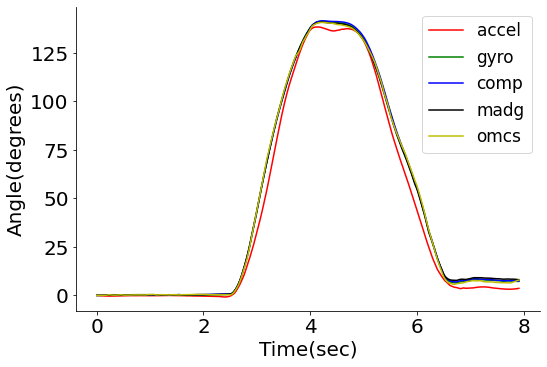

In [15]:
plt.rcParams["figure.figsize"] = [8.00, 5.50]
plt.rcParams["figure.autolayout"] = True
fg, ax = plt.subplots()
ax.plot(_2322[5].Time,_2322[0],'r')
ax.plot(_2322[5].Time,_2322[1],'g')
ax.plot(_2322[5].Time,_2322[2],'b')
ax.plot(_2322[5].Time,_2322[3],'k')
ax.plot(_2322[5].Time,_2322[4],'y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
plt.xlabel('Time(sec)')
plt.ylabel('Angle(degrees)')
plt.legend(['accel','gyro','comp','madg','omcs'],loc='upper right', fontsize=17)
plt.savefig(r'D:\sample_output.svg')
plt.show()